In [87]:
import pandas as pd
from extract_targets import extract

NOTE:

-- Before you start, note that a few of the files were too big for github, so the zipped version is available. Please unzip

First, we load the database of the targets to check for. 

This has been done by scraping a recent article on top 50 CROs, however, we can choose any number of top candidates we want. e.g. I choose 20 for the sake of this project.

Since this step takes some time, **it has been done beforehand!** You can just skip this step

In [88]:
#By not providing any argument, it defaults to the entire list,
#  however, if we want the top 20 we can just call it with 20
if False:
    extract(50)

The extract saves the data in this path so we can just load it whenever without recalling the above step

In [89]:
targets = pd.read_csv("data/targets.csv")
targets.head()

,name,specialization,notable_client
0,ICON plc,Full-service,"Pfizer, Bristol Myers Squibb"
1,IQVIA,Full-service,"Novartis, Merck"
2,Parexel,"Late-phase, full-service","GlaxoSmithKline, AstraZeneca"
3,Syneos Health,Full-service,"Eli Lilly, Johnson & Johnson"
4,Medpace,"Niche (oncology, rare disease)","Roche, Gilead"


To create standardized names, we used AI to get us any other name that any of these companies have been known by in the past 5 years, creating a mapping from the possible other names to the names in these lists. These data were saved in overlaps.json (Note that this list was done with the full 50 companies in the article, if you add any other company and they are known by a significantly different name in the past few years, make sure to add the entries in the dataset)

For example, we realized that a few of the companies have been acquired in the past few years, so we mapped the old ones to the new ones for more accurate scoring.

Now it's time to Scrape and structure CRO regulatory enforcement data - the following have been imported from the FDA dashboard:
1. inspection_details
2. inspection_citation_details
3. published_483s

With the link: [datadashboard.fda.gov](https://datadashboard.fda.gov/oii/cd/inspections.htm)

The warning letters were acquired from the FDA website, but a different link this time: [www.fda.gov](https://www.fda.gov/inspections-compliance-enforcement-and-criminal-investigations/compliance-actions-and-activities/warning-letters)

The data were downloaded in the form of excel and were converted it to csv

In this stage we just load the data - and standardize each one for ease in combining.

Here is How our standardizing works: 

In [90]:
overlaps = pd.read_json("overlaps.json")
overlaps.head(2)

,non_standardized,cro_name_standardized
0,quintiles,IQVIA
1,ims health,IQVIA


In [91]:
#Using Fuzzy Search for best result
from rapidfuzz import process, fuzz

# 2- build a list of the strings to match against
choices = overlaps['non_standardized'].tolist()
def standardize(df,choices:list, non_standard_name:str):
    # 1- Making sure we have a column of lowercase values without Nans.
    df["name_lower"] = df[non_standard_name].str.lower()
    df = df.dropna(subset=['name_lower']).copy()
    df['name_lower'] = df['name_lower'].astype(str)

    # 2- apply to df — this creates a new column 'matched_nonstd'
    df['matched_nonstd'] = df['name_lower'].apply(lambda nm: get_best_match(nm, choices))

    # 3- drop anything that didn’t get a match
    df = df.dropna(subset=['matched_nonstd']).reset_index(drop=True)

    # 4- map that back to the standardized name
    mapping = overlaps.set_index('non_standardized')['cro_name_standardized'].to_dict()
    df['cro_name_standardized'] = df['matched_nonstd'].map(mapping)
    df = df.drop(["matched_nonstd", "name_lower"], axis=1)

    return df

# helper that returns (best_match, score or None)
def get_best_match(s, choices, thresh=90):
    if not s:
        return None
    match, score, _ = process.extractOne(s, choices, scorer=fuzz.token_sort_ratio)
    if score >= thresh:
        return match
    else:
        return None

In [92]:
# Load - Standardize - Show
inspection_details = pd.read_csv("data/inspection_details_since2019.csv")
inspection_details = standardize(inspection_details, choices, "Legal Name")
inspection_details.head(2)

,FEI Number,Legal Name,City,State,Zip,Country/Area,Fiscal Year,Inspection ID,Posted Citations,Inspection End Date,Classification,Project Area,Product Type,Additional Details,FMD-145 Date,cro_name_standardized
0,3006799640,"Frontage Laboratories, Inc.",Exton,Pennsylvania,19341,United States,2025,1258228,Yes,2025-01-10,Voluntary Action Indicated (VAI),Pre-Approval Eval. of Animal Drugs and Food Ad...,Veterinary,-,2025-02-11 00:00:00,Frontage Labs
1,3016465959,ICON Plc,Dublin 18,-,-,Ireland,2024,1242958,No,2024-05-24,No Action Indicated (NAI),Bioresearch Monitoring,Drugs,"Sponsor, Contract Research Organization",-,ICON plc


In [93]:
warning_letters = pd.read_csv("data/warning-letters.csv")
warning_letters = standardize(warning_letters, choices, "Company Name")
#Just a side note, becuase these companies are top companies 
#    - I don't think they did get any warning letters or 483s in the past 5 years - however, I kept the logic here for when we want to check more companies
warning_letters.head(2)

,Posted Date,Letter Issue Date,Company Name,Issuing Office,Subject,Response Letter,Closeout Letter,cro_name_standardized


In [94]:
published_483 = pd.read_csv("data/Published_483s.csv")
published_483 = standardize(published_483, choices, "Legal Name")
published_483.head(2)

,Record Date,FEI Number,Legal Name,Record Type,Publish Date,Download,Record ID,cro_name_standardized


In [95]:
icd = pd.read_csv("data/Inspection_Citation_Details.csv")
icd = standardize(icd, choices, "Legal Name")
icd.head(2)

,Inspection ID,FEI Number,Legal Name,Inspection End Date,Program Area,Act/CFR Number,Short Description,Long Description,cro_name_standardized
0,1258228,3006799640,"Frontage Laboratories, Inc.",2025-01-10,Drugs,21 CFR 211.84(d)(2),Reports of Analysis (Components),Reports of analysis from component suppliers a...,Frontage Labs
1,1258228,3006799640,"Frontage Laboratories, Inc.",2025-01-10,Drugs,21 CFR 211.160(b),Scientifically sound laboratory controls,Laboratory controls do not include the establi...,Frontage Labs


Now it's time to merge datasets, we merge in the following order:

- Inspection details and Inspection Citation Defails
- result of above and published_483
- result of above and warning letters

We clean and each stage and we also clean in the end. 

In [96]:
# We only care about the companies that have been inspected first, then we check for citation details
inspection_merge = pd.merge(inspection_details, icd, how="left", left_on="Inspection ID", right_on="Inspection ID")

Now we clean the merge:

1. make sure the duplicated columns are actually duplicated and not have different values
2. get rid of them and rename the columns

In [97]:
# 1.
inspection_merge.columns

Index(['FEI Number_x', 'Legal Name_x', 'City', 'State', 'Zip', 'Country/Area',
       'Fiscal Year', 'Inspection ID', 'Posted Citations',
       'Inspection End Date_x', 'Classification', 'Project Area',
       'Product Type', 'Additional Details', 'FMD-145 Date',
       'cro_name_standardized_x', 'FEI Number_y', 'Legal Name_y',
       'Inspection End Date_y', 'Program Area', 'Act/CFR Number',
       'Short Description', 'Long Description', 'cro_name_standardized_y'],
      dtype='object')

In [98]:
# Since there are no differences, we can merge the columns
inspection_merge[((inspection_merge['Inspection End Date_y'] != inspection_merge['Inspection End Date_x']) |
                 (inspection_merge['cro_name_standardized_y'] != inspection_merge['cro_name_standardized_x']) |
                 (inspection_merge['FEI Number_y'] != inspection_merge['FEI Number_x']) ) &
                 (inspection_merge["FEI Number_y"].notna())][
                     ["FEI Number_x",
                       "FEI Number_y",
                       'Inspection End Date_x',
                       'Inspection End Date_y',
                       "cro_name_standardized_x", 
                       "cro_name_standardized_y"]
                ]

,FEI Number_x,FEI Number_y,Inspection End Date_x,Inspection End Date_y,cro_name_standardized_x,cro_name_standardized_y


In [99]:
# Now we combine the columns and get rid of the old ones
inspection_merge['FEI Number']        = inspection_merge['FEI Number_x'].fillna(inspection_merge['FEI Number_y'])
inspection_merge['Inspection End Date'] = inspection_merge['Inspection End Date_x'].fillna(inspection_merge['Inspection End Date_y'])
inspection_merge['cro_name_standardized']        = inspection_merge['cro_name_standardized_x'].fillna(inspection_merge['cro_name_standardized_y'])
inspection_merge['Legal Name']        = inspection_merge['Legal Name_x'].fillna(inspection_merge['Legal Name_y'])


inspection_merge = inspection_merge.drop([
    'FEI Number_x','FEI Number_y',
    'Inspection End Date_x','Inspection End Date_y',
    'cro_name_standardized_x','cro_name_standardized_y',
    'Legal Name_x','Legal Name_y'
], axis=1)

 - Merging published 483 with these data


In [100]:
inspection_merge = pd.merge(
    inspection_merge, 
    published_483, 
    how="outer", 
    left_on=["FEI Number","Inspection End Date"], 
    right_on=["FEI Number", "Record Date"])

In [101]:
# Again we combine the columns and get rid of the old ones
inspection_merge['Inspection End Date'] = inspection_merge['Inspection End Date'].fillna(inspection_merge['Record Date'])
inspection_merge['cro_name_standardized']        = inspection_merge['cro_name_standardized_x'].fillna(inspection_merge['cro_name_standardized_y'])
inspection_merge['Legal Name']        = inspection_merge['Legal Name_x'].fillna(inspection_merge['Legal Name_y'])

inspection_merge = inspection_merge.drop([
    'cro_name_standardized_x','cro_name_standardized_y',
    'Legal Name_x','Legal Name_y',
    'Record Date'
], axis=1)

- Combine with Warning Letters

In [102]:
regulatory_data = pd.merge(
    inspection_merge,
    warning_letters,
    how="outer",
    left_on="cro_name_standardized",
    right_on="cro_name_standardized"
)

- Now we clean it out to include only the columns that we want: (+adding the flags)

In [103]:
# We also add the flags for if there is a 483 or a warning letter
regulatory_data["has 483"] = regulatory_data["Record Type"] == 483
regulatory_data["has warning"] = regulatory_data["Subject"].notna()

# and normalize the flags
regulatory_data["form_483_flag"] = regulatory_data["has 483"].astype(int)
regulatory_data["warning_letter_flag"] = regulatory_data["has warning"].astype(int)


regulatory_data = regulatory_data.drop([
    # Inspection Details extra Columns
    "City", # We werent asked about location
    "State",
    "Zip",
    "Country/Area",
    "Product Type",
    "Additional Details", # Long Description and FMD-145 Date are just unnesseccary information at this point
    "FMD-145 Date",
    "Fiscal Year",
    
    # Inspection Citation Details Extra Columns
    "Program Area",
    "Long Description",

    # Published 483 Extra Columns
    "Record Type", # Record Type only gets the value 483, so we can just get rid of it. 

    #Warning Letters Extra Columns
    "Company Name", # Same as Legal Name
    "Response Letter", # We removed unimportant details about the letters here (e.g. issuing officer) 
    #                      - atp we onlt care about it's existance or not.
    "Issuing Office",
    "Posted Date",
    "Letter Issue Date",
    "Closeout Letter",

    # Extra
    "has 483",
    "has warning",
], axis=1)


In [104]:
regulatory_data.rename(columns={"Inspection End Date": "date_of_inspection",
                                "Project Area": "type_of_issue",
                                
                                }, inplace=True)
regulatory_data.rename(columns={"Inspection End Date": "date_of_inspection"}, inplace=True)

#Normalizing the data
for c in regulatory_data.columns:
    new = c.lower().replace(" ", "_")
    if c != new:
        regulatory_data.rename(columns={c:new}, inplace=True) 

regulatory_data["source"] = "FDA_DASHBOARD"

In [105]:
regulatory_data.columns

Index(['inspection_id', 'posted_citations', 'classification', 'type_of_issue',
       'act/cfr_number', 'short_description', 'fei_number',
       'date_of_inspection', 'publish_date', 'download', 'record_id',
       'cro_name_standardized', 'legal_name', 'subject', 'form_483_flag',
       'warning_letter_flag', 'source'],
      dtype='object')

In [106]:
# we just rearrange the columns to make it easier to understand
regulatory_data = regulatory_data[['fei_number', 'cro_name_standardized', 'inspection_id', 'date_of_inspection', 'type_of_issue', 'classification', 'act/cfr_number', 'short_description', 'publish_date', 'form_483_flag' , 'warning_letter_flag', 'download', 'source', 'record_id']]

We save our merged dataset for ease in later use.

In [107]:
regulatory_data.to_csv("data/regulatory_data_merged.csv")

Now to get the data from trial-level performance data.

We got the data from the following data [aact.ctti-clinicaltrials.org](https://aact.ctti-clinicaltrials.org/downloads) through the SQL dump, and then used postgreSQL to filter out the data we need and save it in our local device (This was annoying ngl) -- More details in markdown.

So we just laod it now

In [108]:
# load - standardize - show
CT_summary = pd.read_csv("data/clinicalTrials_summary.csv")
CT_summary = standardize(CT_summary, choices, "cro_involved")
CT_summary.head(2)

,trial_identifier,cro_involved,withdrawals,enrolled,start_date,completion_date,estimated_completion_date,dropout_rate,country,city,cro_name_standardized
0,NCT03869983,Syneos Health,NaN,24.0,2019-04-12,2019-05-15,NaN,NaN,Canada,Québec City,Syneos Health
1,NCT04712396,Parexel,NaN,11.0,2021-02-01,2021-03-25,NaN,NaN,Germany,Berlin,Parexel


In [109]:
CT_summary['source'] = 'ClinicalTrials'

In [110]:
# Now we only get the CROS that are our targets - we will also get rid of the pervious names that are irrelevant
regulatory_data = pd.merge(regulatory_data, targets, how="left", left_on="cro_name_standardized", right_on="name").dropna(subset="name").drop({"name"}, axis=1)
CT_summary = pd.merge(CT_summary, targets, how="left", left_on="cro_name_standardized", right_on="name").dropna(subset="name").drop({"name", "cro_involved"}, axis=1)

In [111]:
unified_schema = pd.concat([regulatory_data, CT_summary])
unified_schema.head()

,fei_number,cro_name_standardized,inspection_id,date_of_inspection,type_of_issue,classification,act/cfr_number,short_description,publish_date,form_483_flag,...,notable_client,trial_identifier,withdrawals,enrolled,start_date,completion_date,estimated_completion_date,dropout_rate,country,city
0,1.523647e+06,Charles River,1131689.0,2020-10-01,Bioresearch Monitoring,Voluntary Action Indicated (VAI),NaN,NaN,NaN,0.0,...,"Biogen, Regeneron",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.006500e+09,Charles River,1224863.0,2023-11-17,"Human Cellular, Tissue, and Gene Therapies",No Action Indicated (NAI),NaN,NaN,NaN,0.0,...,"Biogen, Regeneron",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.007838e+09,Charles River,1097850.0,2019-07-26,Bioresearch Monitoring,Voluntary Action Indicated (VAI),NaN,NaN,NaN,0.0,...,"Biogen, Regeneron",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.015687e+09,Charles River,1123355.0,2020-03-19,Drug Quality Assurance,No Action Indicated (NAI),NaN,NaN,NaN,0.0,...,"Biogen, Regeneron",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.015687e+09,Charles River,1191225.0,2022-11-09,Drug Quality Assurance,No Action Indicated (NAI),NaN,NaN,NaN,0.0,...,"Biogen, Regeneron",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
unified_schema.to_csv("data/unified_schema.csv", index=False)

## Evaluating

To summarize our key finidngs, we realized that the 20 companies bareley recieved any form 483 or warning letter in the past 5 years (which is what we were asked to cover), hence this is not a great indicator for how the CROs are behaving However, what we did understand from this task is written bellow. 


There are around 2-3 inspections each year for each company which makes it hard to base our scoring criteria on how many inspections they have recently had. Moreover, we want the current state of a CRO which is why it's also hard to go too back in time to how the company was doing back then. To have a better understand of what a company does, other facotrs should be taken into conisderation. -- Moreover, when going through the files, we realized that some of the inpsection officier have not recorded all their data and hand written it, which to get a better sense of how they work, it's better to get access to that.


Here is how each company is behvaing according to our current data with visualizations using matplotlib:

In [113]:
import matplotlib.pyplot as plt
import numpy as np

In [114]:
# Here are the companies who had an appearance on the list 
#  - note that if a company is not on a this list doesn't neccessarly mean that the company is good or bad
#  It simply means that the inspection officer took notes on paper and did not electrolize them. 
regulatory_data['cro_name_standardized'].unique()

array(['Charles River', 'Fortrea', 'Frontage Labs', 'ICON plc', 'IQVIA',
       'Lotus Clinical Research', 'Parexel', 'Precision for Medicine',
       'Syneos Health', 'Worldwide Clinical Trials'], dtype=object)

In [115]:
regulatory_data.head(2)

,fei_number,cro_name_standardized,inspection_id,date_of_inspection,type_of_issue,classification,act/cfr_number,short_description,publish_date,form_483_flag,warning_letter_flag,download,source,record_id,specialization,notable_client
0,1523647,Charles River,1131689,2020-10-01,Bioresearch Monitoring,Voluntary Action Indicated (VAI),NaN,NaN,NaN,0,0,NaN,FDA_DASHBOARD,NaN,"Preclinical, early-phase","Biogen, Regeneron"
1,3006500433,Charles River,1224863,2023-11-17,"Human Cellular, Tissue, and Gene Therapies",No Action Indicated (NAI),NaN,NaN,NaN,0,0,NaN,FDA_DASHBOARD,NaN,"Preclinical, early-phase","Biogen, Regeneron"


<BarContainer object of 10 artists>

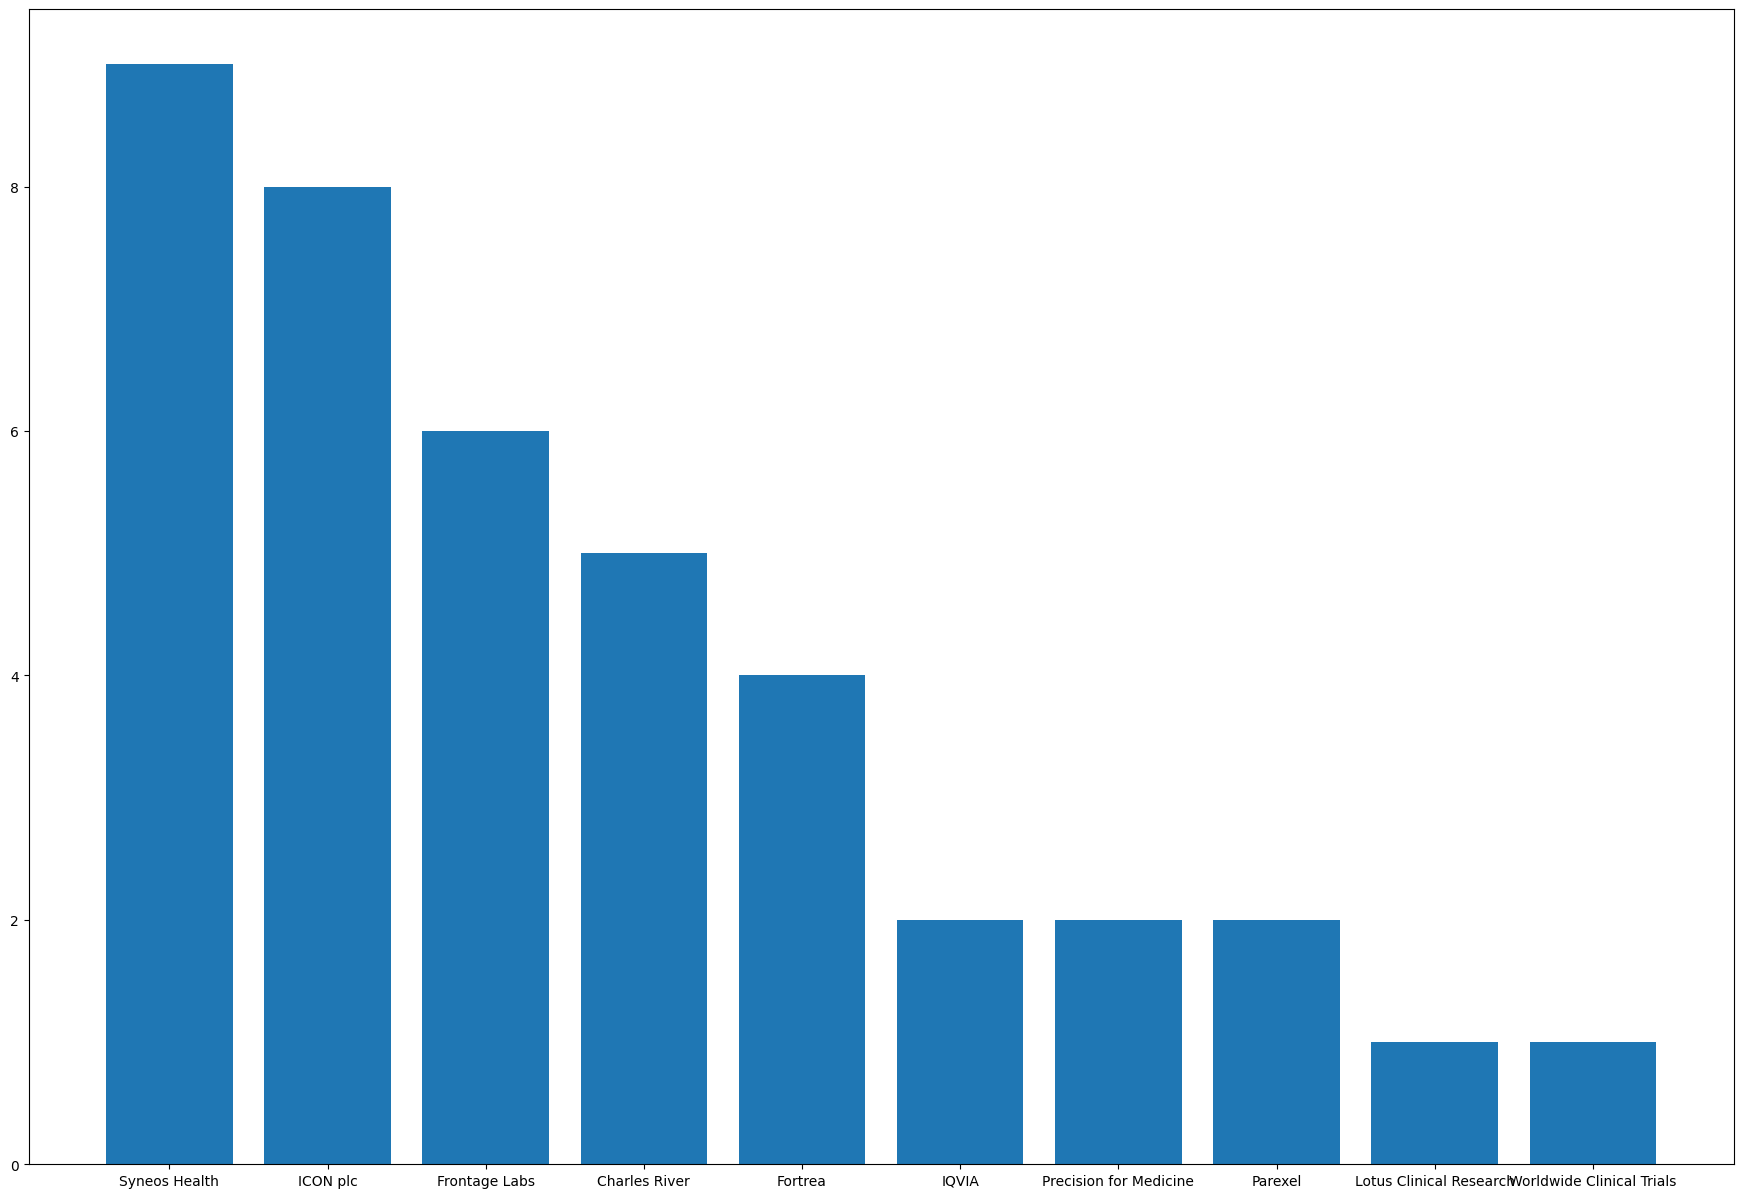

In [116]:
count = regulatory_data['cro_name_standardized'].value_counts()
plt.figure(figsize=(22,15))
plt.bar(count.index, count.values)

According to this graph, Syneon Health had the most visits which suggests that something might have been wrong, and the others in the middle must have been the ones with normal activities.

In [135]:
# we create a copy to mess around with it:
ct_copy = CT_summary.copy()
ct_copy.columns

Index(['trial_identifier', 'withdrawals', 'enrolled', 'start_date',
       'completion_date', 'estimated_completion_date', 'dropout_rate',
       'country', 'city', 'cro_name_standardized', 'source', 'specialization',
       'notable_client'],
      dtype='object')

When talking about Clinical Trials, there are several ways to measure success, one being how far off they were from each estimation, and the dropout rate.

1. Estimation Completion vs actual completion:

In [136]:
# make sure your columns are datetime dtype
ct_copy['estimated_completion_date'] = pd.to_datetime(
    ct_copy['estimated_completion_date'], errors='coerce'
)
ct_copy['completion_date'] = pd.to_datetime(
    ct_copy['completion_date'], errors='coerce'
)

# build a mask of rows where both dates are present
both_present = (
    ct_copy['estimated_completion_date'].notna() &
    ct_copy['completion_date'].notna()
)

# compute the difference only where both are non-null; elsewhere you get NaT
ct_copy['diff'] = (
    ct_copy['estimated_completion_date']
    - ct_copy['completion_date']
)
# ct_copy[['cro_name_standardized', 'diff']]

cro_name_standardized
CTI Clinical                 526 days
Clinlogix                   1742 days
FHI Clinical                  62 days
Fortrea                      685 days
ICON plc                    1658 days
PSI CRO                     1829 days
Parexel                      850 days
ProPharma Group              177 days
Syneos Health                654 days
Worldwide Clinical Trials    269 days
Name: diff, dtype: timedelta64[ns]


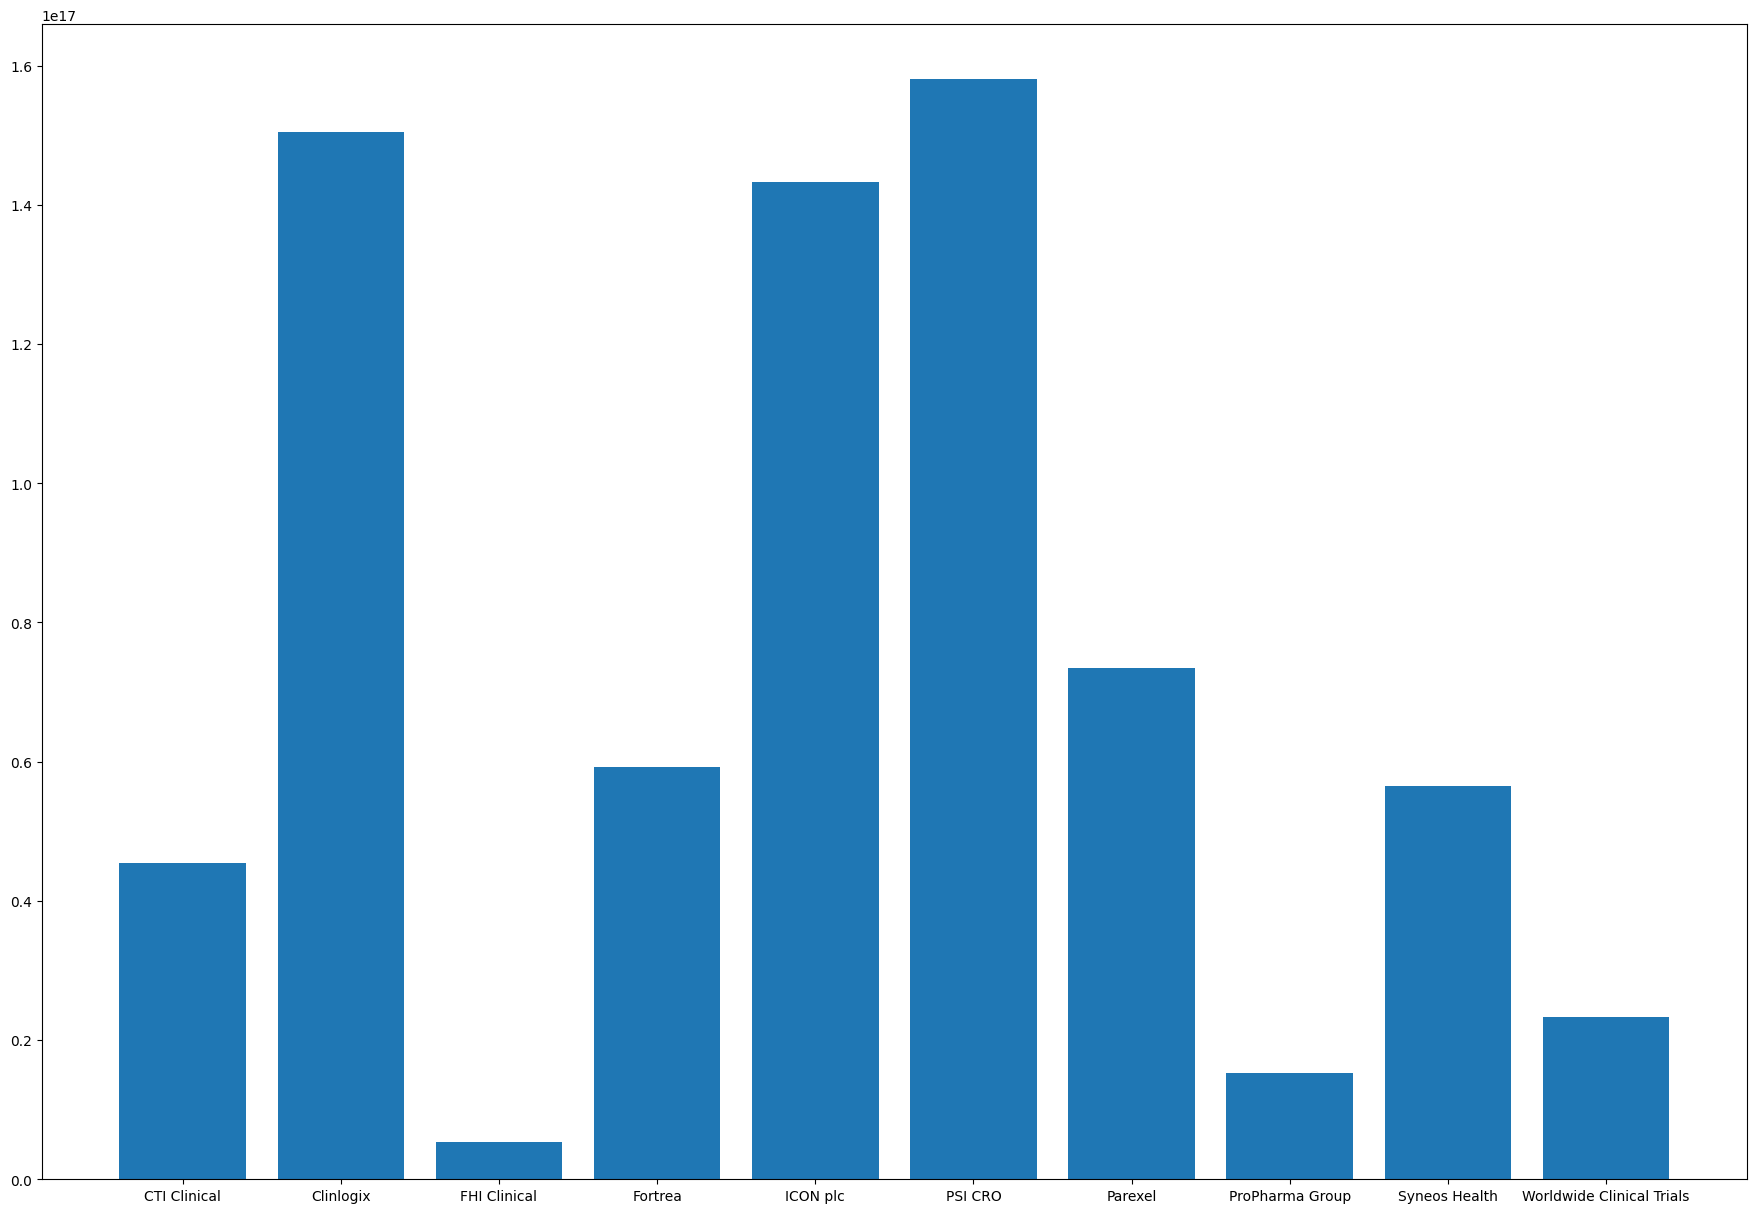

In [140]:
med = ct_copy[ct_copy['estimated_completion_date'].notna() & ct_copy['completion_date'].notna()].groupby('cro_name_standardized')['diff'].median()
plt.figure(figsize=(22,15))
plt.bar(med.index, med.values)
print(med)

this shows that some companies like Clinogix and PSI CRO underestimate their studies by too long which is not a good sign. 

Moreover, this also shows that some CROs like IQVIA don't share their clinical trials data (which was also faced when going through [clinicaltrials.gov](https://clinicaltrials.gov/))

Now the last piece is dropout rates

cro_name_standardized
Atlantic Research Group      0.121951
CTI Clinical                 0.118056
Celerion                     0.032258
Clinipace                    1.000000
Clinlogix                    0.209877
FHI Clinical                 0.083333
Fortrea                      0.206290
George Clinical              0.481240
ICON plc                     0.207531
IQVIA                        0.360146
Lotus Clinical Research      0.072289
Parexel                      0.117280
Pharm-Olam                   0.112926
Syneos Health                0.224785
Veristat                     0.032609
Worldwide Clinical Trials    0.171053
Name: dropout_rate, dtype: float64


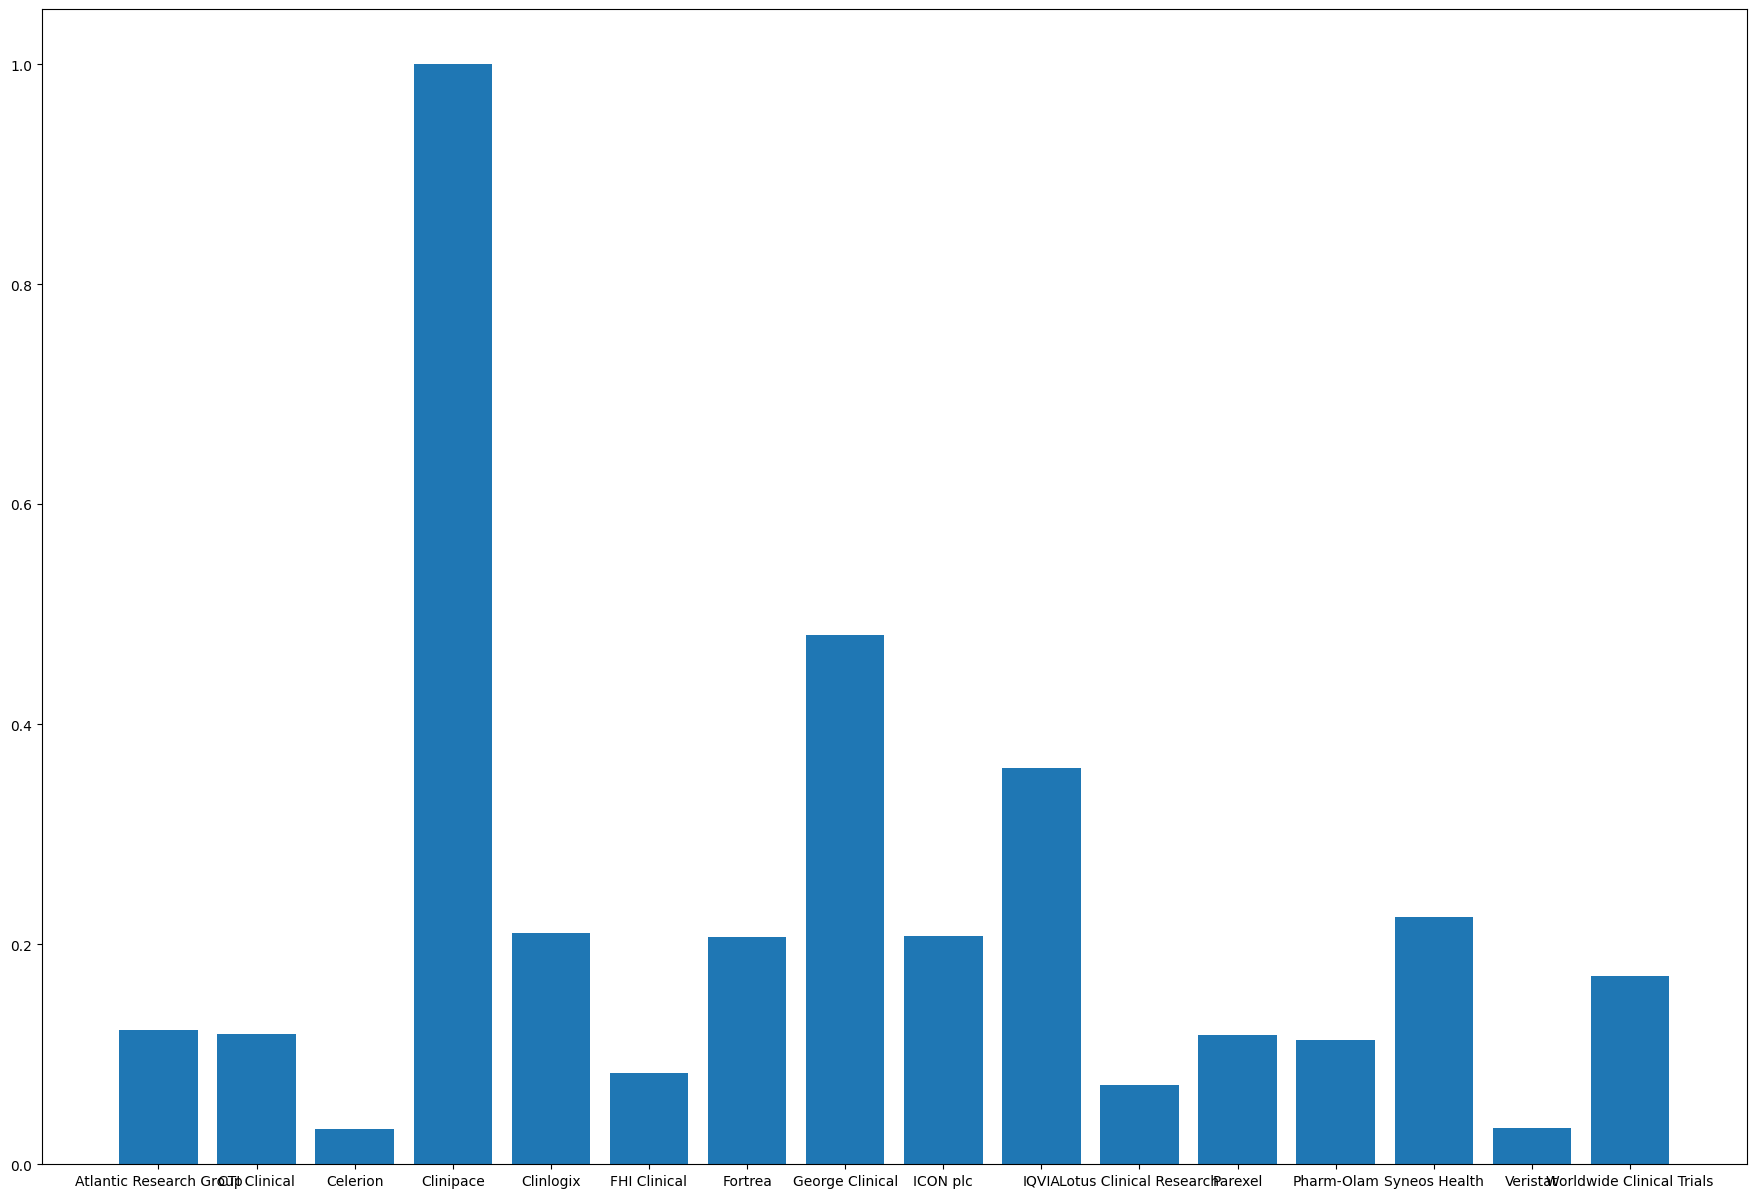

In [141]:
med = ct_copy[ct_copy['dropout_rate'].notna()].groupby('cro_name_standardized')['dropout_rate'].median()
plt.figure(figsize=(22,15))
plt.bar(med.index, med.values)
print(med)

Again this showcases that Clinpace is struggelling with the dropout rates or that there are errors in their systems, and in the second place, George Clinical is struggelling the most. Moreover, it seems as if Celeriona and Veristat are doing the best

In [143]:
ct_copy.columns

Index(['trial_identifier', 'withdrawals', 'enrolled', 'start_date',
       'completion_date', 'estimated_completion_date', 'dropout_rate',
       'country', 'city', 'cro_name_standardized', 'source', 'specialization',
       'notable_client', 'diff'],
      dtype='object')

Overall, it seems as if Fortrea is doing the best considering that they have the middle ground on the number of visits in a year which showcases that they were an average target to the eyes of FDA, moreover, they have lower values on dropout rates and on the difference between the actual and estimated completion dates. 